# LSTM Auto-Regresive Forecasting in prices of Bayo Bean

## Part 1: Data Adquisition

In [44]:
# importing libraries
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

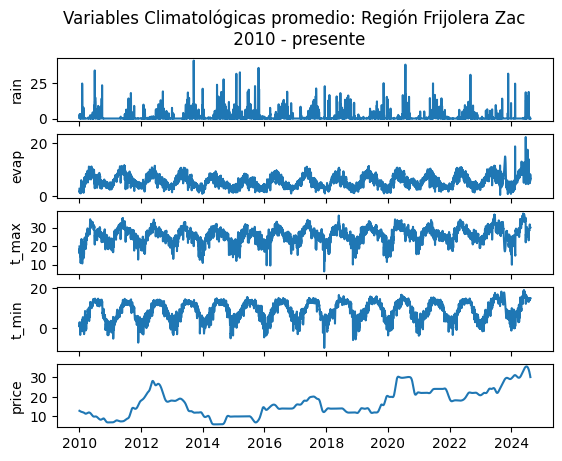

In [75]:
# Data Collection

data = pd.read_csv('clean_data/clean_data_simple.csv',index_col='date')
data.index = pd.to_datetime(data.index)
data = data.asfreq('D')

f, ax = plt.subplots(5,1, sharex=True)
for i in range(5):
    ax[i].plot(data.loc['2010-01-01':].index.values,
                data[data.columns[i]].loc['2010-01-01':].values)
    ax[i].set_ylabel(data.columns[i])

a1 = f.suptitle('Variables Climatológicas promedio: Región Frijolera Zac \n 2010 - presente')

In [46]:
print(data.info())
data

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9710 entries, 1998-01-15 to 2024-08-15
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   rain    9710 non-null   float64
 1   evap    9710 non-null   float64
 2   t_max   9710 non-null   float64
 3   t_min   9710 non-null   float64
 4   price   9710 non-null   float64
dtypes: float64(5)
memory usage: 713.2 KB
None


,rain,evap,t_max,t_min,price
date,,,,,
1998-01-15,0.000000,3.466429,18.441667,-3.583333,5.250000
1998-01-16,0.000000,3.679286,20.520833,-4.566667,5.248118
1998-01-17,0.000000,3.032143,18.616667,-1.270833,5.247415
1998-01-18,0.000417,3.889286,20.758333,1.129167,5.247856
1998-01-19,0.000000,3.796429,20.779167,-0.516667,5.249404
...,...,...,...,...,...
2024-08-11,0.000000,6.690000,30.250000,14.583333,30.990924
2024-08-12,0.000000,6.892500,30.400000,14.500000,30.754172
2024-08-13,0.000000,6.317500,30.060000,14.740000,30.510153


Al parecer no hay datos suficientes para predecir los precios del frijol

<Axes: >

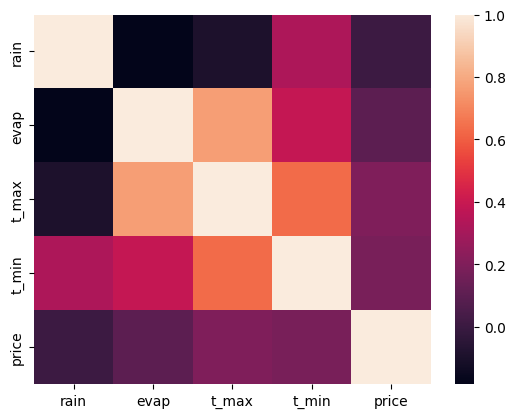

In [47]:
sns.heatmap(data.corr())

## Part 2: Data preprocessing

In [76]:
# to check if the date ranges are ok
fecha_inicio = data.index.min()
fecha_fin = data.index.max()
rango_completo = pd.date_range(start=fecha_inicio, end=fecha_fin, freq='D')

fechas_presentes = data.index
fechas_faltantes = rango_completo[~rango_completo.isin(fechas_presentes)]

# Cuenta las fechas faltantes
num_fechas_faltantes = len(fechas_faltantes)
print(f"Número de fechas faltantes: {num_fechas_faltantes}")

# Si deseas ver las fechas faltantes específicas:
print(f'Fecha inicio: {fecha_inicio}, fecha fin: {fecha_fin}')
print("Fechas faltantes:")
print(fechas_faltantes)

Número de fechas faltantes: 0
Fecha inicio: 1998-01-15 00:00:00, fecha fin: 2024-08-15 00:00:00
Fechas faltantes:
DatetimeIndex([], dtype='datetime64[ns]', freq='D')


## Part 3: Model Development and predictions

In [77]:
train_loc = int(len(data) * 0.80) # 80% of data to train
validation_loc = int(len(data) * 0.95) # 80 to 95 (15%) of data to validate

train_dataset = data.iloc[:train_loc].asfreq('D')
validation_dataset = data.iloc[train_loc:validation_loc].asfreq('D')
test_dataset = data.iloc[validation_loc:].asfreq('D')

In [50]:
print(train_dataset)
print(validation_dataset)
print(test_dataset)


                rain      evap      t_max     t_min      price
date                                                          
1998-01-15  0.000000  3.466429  18.441667 -3.583333   5.250000
1998-01-16  0.000000  3.679286  20.520833 -4.566667   5.248118
1998-01-17  0.000000  3.032143  18.616667 -1.270833   5.247415
1998-01-18  0.000417  3.889286  20.758333  1.129167   5.247856
1998-01-19  0.000000  3.796429  20.779167 -0.516667   5.249404
...              ...       ...        ...       ...        ...
2019-04-18  0.000000  7.146667  27.007143  6.964286  14.044818
2019-04-19  0.000000  7.617273  27.142857  5.239286  14.060710
2019-04-20  0.000000  8.320833  29.950000  6.188462  14.076772
2019-04-21  0.000000  7.762500  30.546154  7.992308  14.092824
2019-04-22  0.000000  9.117500  30.625000  8.642857  14.108682

[7768 rows x 5 columns]
                rain      evap      t_max      t_min      price
date                                                           
2019-04-23  0.000000  8.2191

In [190]:
import keras
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
import skforecast
from sklearn.preprocessing import MinMaxScaler
from skforecast.ForecasterRnn import ForecasterRnn
from skforecast.ForecasterRnn.utils import create_and_compile_model
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries

In [191]:
series = ['price','rain','t_max','t_min','evap'] # Series utilizadas
levels = ['price'] # Series a predecir
lags = 180
steps = 30


model = create_and_compile_model(
    series=train_dataset,
    levels=levels,
    lags=lags,
    steps=steps,
    recurrent_layer='LSTM',
    recurrent_units=[100,50],
    dense_units=[64,32],
    optimizer=Adam(learning_rate=0.0005),
    loss=MeanSquaredError(),
)
model.summary()



keras version: 3.6.0
Using backend: tensorflow
tensorflow version: 2.17.0


Model: "functional_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_32 (InputLayer)     │ (None, 180, 5)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_63 (LSTM)                  │ (None, 180, 100)       │        42,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_64 (LSTM)                  │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 64)             │         3,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_84 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_85 (Dense)                │ (None, 30)             │           990 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_32 (Reshape)            │ (None, 30, 1)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,934 (308.34 KB)

 Trainable params: 78,934 (308.34 KB)

 Non-trainable params: 0 (0.00 B)

In [192]:
forecaster = ForecasterRnn(
    regressor=model,
    levels=levels,
    lags=lags,
    steps=steps,
    transformer_series=MinMaxScaler(),
    fit_kwargs={
        "epochs":2,
        "batch_size":128,
        "series_val":validation_dataset,
        "callbacks": [
            EarlyStopping(monitor="val_loss", patience=5)
        ]
    },
)

forecaster.fit(train_dataset)

Epoch 1/2
60/60 ━━━━━━━━━━━━━━━━━━━━ 64s 971ms/step - loss: 0.0909 - val_loss: 0.0633
Epoch 2/2
60/60 ━━━━━━━━━━━━━━━━━━━━ 58s 967ms/step - loss: 0.0120 - val_loss: 0.0140


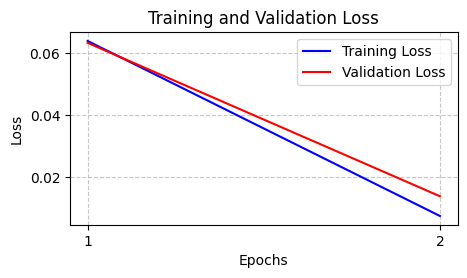

In [193]:
fig, ax = plt.subplots(figsize=(5, 2.5))
forecaster.plot_history(ax=ax)

In [194]:
predictions = forecaster.predict()

In [195]:
metrics, predictions = backtesting_forecaster_multiseries(
    forecaster=forecaster,
    steps=int(forecaster.max_step),
    series=data,
    levels=forecaster.levels,
    initial_train_size=len(data.iloc[:validation_loc]),
    metric='mean_absolute_error',
    verbose=False,
    refit=False
)

Epoch 1/2
71/71 ━━━━━━━━━━━━━━━━━━━━ 72s 976ms/step - loss: 0.0025 - val_loss: 0.0060
Epoch 2/2
71/71 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - loss: 0.0015 - val_loss: 0.0054


100%|██████████| 17/17 [00:03<00:00,  5.38it/s]


In [196]:
metrics

,levels,mean_absolute_error
0,price,1.093773


In [197]:
# Error mse en % respecto a la media de la serie
# ==============================================================================
rel_mse = 100 * metrics['mean_absolute_error'].loc[0] / np.mean(data["price"])
print(f"Media de la serie: {np.mean(data['price']):0.2f}")
print(f"Error mae relativo: {rel_mse:0.2f} %")

Media de la serie: 12.88
Error mae relativo: 8.49 %


In [198]:
predictions

,price
2023-04-18,24.513020
2023-04-19,24.344793
2023-04-20,24.568167
2023-04-21,24.626535
2023-04-22,24.574432
...,...
2024-08-11,30.352987
2024-08-12,35.087261
2024-08-13,34.161755
2024-08-14,34.705574


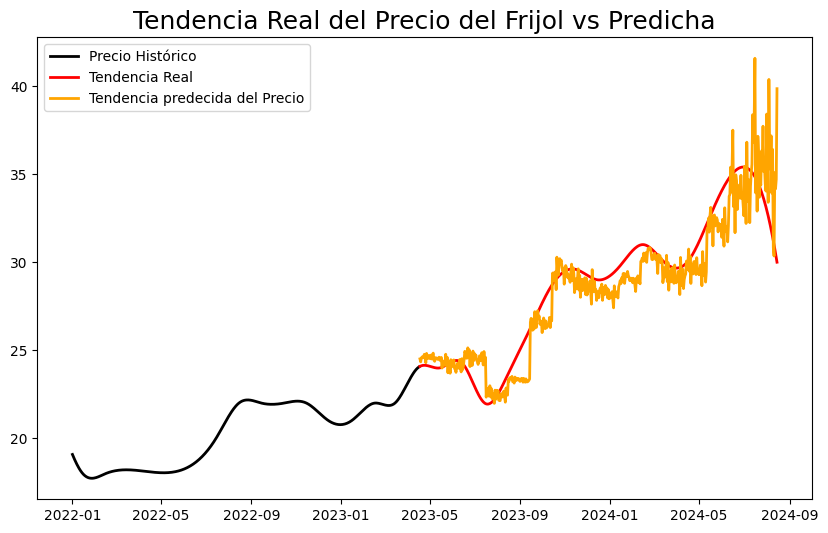

In [199]:
plt.figure(figsize=(10,6))
plt.plot(validation_dataset.loc['2022-01-01':].index, validation_dataset['price'].loc['2022-01-01':], label = 'Precio Histórico', lw=2, color='black')
plt.plot(test_dataset.index, test_dataset['price'], label = 'Tendencia Real', color = 'red', lw = 2)
plt.plot(predictions.index, predictions['price'], label = 'Tendencia predecida del Precio', lw=2, color = 'orange')
plt.legend()
# plt.text(20240*0.865,32, f'Modelo simple_1_{epochs}_{learning_rate}_{sequence_length}_{history.history['val_loss'][-1]}', fontsize=12)
t = plt.title('Tendencia Real del Precio del Frijol vs Predicha', fontsize = 18)

In [201]:
from skforecast.utils import save_forecaster

save_forecaster( forecaster=forecaster, file_name='models/forecaster_32_2_0.0005_na_0.0054.joblib', verbose=True)



ForecasterRnn 
Regressor: <Functional name=functional_32, built=True> 
Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180] 
Transformer for series: MinMaxScaler() 
Window size: 180 
Target series, levels: ['price'] 
Multivariate series (names): ['rain', 'evap', 't_max', 't_min', 'price'] 
Maximum steps predicted: 